In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math as mt

### Initial Conditions Definition for Function Testing 

In [2]:

# Initial Testing Conditions 

# Constants
R = 8.3145 # J / mol K
T = 310.15 # K
RT = R*T
F = 96485.33 # C/mole

# Volumes
Ve = 0.8425 #2 #4.54e3  # L cyto water / L cyto
Vx = 0.650 # 1 #0.65  # L matrix water/ L mito
Vi = Vx / .9 * .1 # L intermembrane space water / L mito

# Compartment Volumes
Vcyto = 0.6801 # L / L tissue
Vmito = 0.2882 # L / L tissue

# Dissociation Constants
K_HATP = 2.757e-7
K_KATP = 9.809e-2
K_MATP = 8.430e-5
K_HADP = 4.106e-7
K_KADP = 1.319e-1
K_MADP = 7.149e-4
K_HPi  = 2.308e-7
K_KPi  = 3.803e-1
K_MPi  = 2.815e-2
dissoc_constants = np.array([K_HATP, K_KATP, K_MATP, K_HADP, K_KADP,K_MADP, K_HPi, K_KPi, K_MPi])


# Conditions
pH_outer = 7.2
pH_inner = 7.4
psi = 175 / 1000

Mg  = 1e-3 # M
K   = 100e-3 # M
H   = 10**(-7.2) # note, redundant b/c we have pH # M
O2  = 2.6e-5 # M

ATP_x = 1e-3
ADP_x = 9e-3
Pi_x   = 1e-3
ATP_e = 7.5e-3
ADP_e = 0.5e-3
Pi_e   = 0.5e-3
Crtot = 54e-3 # M # 20e-3 # total creatin
Cr = 0.65 * Crtot

Q_tot    = 1.35e-3
QH2   = 0.5 * Q_tot

NAD_tot  = 2.97e-3
NADH_x = 0.5 * NAD_tot

cytc_tot = 2.7e-3
cytcred = 0.5 * cytc_tot



init_conditions = np.array([ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi])

H_x = 10**(-pH_inner)
H_e = 10**(-pH_outer)

# Binding Polynomials 
K_HATP, K_KATP, K_MATP, K_HADP, K_KADP,K_MADP, K_HPi, K_KPi, K_MPi = dissoc_constants

P_ATPx = 1 + H_x/K_HATP + Mg/K_MATP + K/K_KATP
P_ADPx = 1 + H_x/K_HADP + Mg/K_MADP + K/K_KADP
P_PIx  = 1 + H_x/K_HPi  + Mg/K_MPi  + K/K_KPi 

P_ATPe = 1 + H_e/K_HATP + Mg/K_MATP + K/K_KATP;
P_ADPe = 1 + H_e/K_HADP + Mg/K_MADP + K/K_KADP;
P_PIe  = 1 + H_e/K_HPi  + Mg/K_MPi  + K/K_KPi; 

binding_polys = np.array([P_ATPx, P_ADPx, P_PIx, P_ATPe, P_ADPe, P_PIe])
binding_polys

print()

### F1F0 ATP Synthase 

In [3]:
def J_F1F0(pH_inner, pH_outer, Mg, K, binding_polys, concentrations):
    # Unpack variables 
    ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi = concentrations
    P_ATPx, P_ADPx, P_PIx, P_ATPe, P_ADPe, P_PIe =  binding_polys
    
    H_x = 10**(-pH_inner)
    H_e = 10**(-pH_outer)
    
    # Constants
    X_F1F0 = 812
    n_H = 8/3
    DGr0_F1F0 = -4510

    Keq_prime_F1F0 = np.exp(-(DGr0_F1F0-F*psi*n_H)/(RT)) * (P_ATPx / (P_ADPx * P_PIx)) * (H_e**n_H / H_x**(n_H - 1))
    
    flux = X_F1F0 * (Keq_prime_F1F0 * Pi_x * ADP_x - ATP_x)
    return flux


### Adenine Nucleotide Translocator 

In [4]:
def J_ANT(pH_inner, pH_outer, Mg, K, binding_polys, concentrations):
    # Unpack variables 
    ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi = concentrations
    P_ATPx, P_ADPx, P_PIx, P_ATPe, P_ADPe, P_PIe =  binding_polys
    H_x = 10**(-pH_inner)
    H_e = 10**(-pH_outer)
    
    x_ANT = 0.141
    ADP_i1 = ADP_e/P_ADPe # ADP^3-
    ATP_i1 = ATP_e/P_ATPe # ATP^4-
    ADP_x1 = ADP_x/P_ADPx # ADP^3-
    ATP_x1 = ATP_x/P_ATPx # ATP^4-
    del_D = 0.0167
    del_T = 0.0699
    k2_ANT = 9.54/60
    k3_ANT = 30.05/60
    K_D_o_ANT = 38.89e-6
    K_T_o_ANT = 56.05e-6
    A = 0.2829
    B = -0.2086
    C = 0.2372
    fi = F*psi/RT
    
    k2_ANT_fi = k2_ANT*np.exp((A*(-3)+B*(-4)+C)*fi)
    k3_ANT_fi = k3_ANT*np.exp((A*(-4)+B*(-3)+C)*fi)
    K_D_o_ANT_fi = K_D_o_ANT*np.exp(3*del_D*fi)
    K_T_o_ANT_fi = K_T_o_ANT*np.exp(4*del_T*fi)
    q = k3_ANT_fi*K_D_o_ANT_fi*np.exp(fi)/(k2_ANT_fi*K_T_o_ANT_fi)
    
    term2 = k2_ANT_fi*ATP_x1*ADP_i1*q/K_D_o_ANT_fi
    term3 = k3_ANT_fi*ADP_x1*ATP_i1/K_T_o_ANT_fi 
    num = term2 - term3
    den = (1 + ATP_i1/K_T_o_ANT_fi + ADP_i1/K_D_o_ANT_fi)*(ADP_x1 + ATP_x1*q)
    flux = x_ANT*num/den
    return flux 



### J_ATPase (Consumption in cytoplasm) 
Note: Ignoring this function for now and using a constant 

In [5]:
def J_ATPase(pH_inner, pH_outer, Mg, K, binding_polys, init_conditions):
    return 0 

### Phosphate Transporter 

In [6]:
def J_PiC(pH_inner, pH_outer, Mg, K, binding_polys, concentrations):
    # Unpack variables 
    ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi = concentrations
    P_ATPx, P_ADPx, P_PIx, P_ATPe, P_ADPe, P_PIe =  binding_polys
    H_x = 10**(-pH_inner)
    H_e = 10**(-pH_outer)
    
    x_PIH = 3.34e7 # mol/s/M/lmito
    k_PIH = 1.61e-3
    a = Pi_e*(H_e/K_HPi)/P_PIe
    p = Pi_x*(H_x/K_HPi)/P_PIx
    flux = (x_PIH/k_PIH)*(H_e*a - H_x*p)/(1+a/k_PIH)/(1+k_PIH)
    return flux 

#x = J_PiC(psi, pH_inner, pH_outer, Mg, K, binding_polys, init_conditions)
#x

### Creatine Kinase 

In [7]:
def J_CK(pH_inner, pH_outer, Mg, K, binding_polys, concentrations):
    # Unpack variables 
    ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi = concentrations
    P_ATPx, P_ADPx, P_PIx, P_ATPe, P_ADPe, P_PIe =  binding_polys
    H_x = 10**(-pH_inner)
    H_e = 10**(-pH_outer)
    CrP = Crtot - Cr
    X_CK = 1e6 #M/s
    kref = 7.14e8 # Wu et al 2008=
    Keq_CK = kref * H_e * P_ATPe / P_ADPe
    #Keq_CK = exp(-DGr0_CK / (R * T)) * H_e * P_ATP / P_ADP 
    '''
    Changed from equation in Bazil et al. to include kref from Wu et al 2008.
    The original equation has a rate that is much too fast for the current
    model
    '''    
    flux = X_CK * (Keq_CK * ADP_e * CrP - ATP_e * Cr) 
    return flux 

#x = J_CK(psi, pH_inner, pH_outer, Mg, K, binding_polys, init_conditions)
#x

# Complexes 1, 3, 4

In [8]:
def J_C1(pH_inner, pH_outer, Mg, K, binding_polys, concentrations):
    ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi = concentrations
    H_x = 10**(-pH_inner)
    H_e = 10**(-pH_outer)
    H_w = 10**(-7)
    NAD_x = NAD_tot - NADH_x
    Q = Q_tot - QH2
    
    DGo_C1 = -69.37 * 1000; # J mol^(-1)
    X_C1 = 4405
    
    DG_H = F * psi + RT * np.log(H_e / H_x)
    Keq_C1 = np.exp(-(DGo_C1 + 4 * DG_H - R * T * np.log(H_x / H_w)) / (R * T))
    return X_C1 * (Keq_C1 * NADH_x * Q - NAD_x * QH2)
    
J_C1(pH_inner, pH_outer, Mg, K, binding_polys, init_conditions)


-0.00384893856608563

In [9]:
def J_C3(pH_inner, pH_outer, Mg, K, binding_polys, concentrations):
    ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi = concentrations
    H_x = 10**(-pH_inner)
    H_e = 10**(-pH_outer)
    H_w = 10**(-7)
    cytcox = cytc_tot - cytcred
    Q = Q_tot - QH2

    DG_H = F * psi + RT * np.log(H_e / H_x)


    
    DGo_C3 = -32.53 * 1000 #J mol^(-1)
    X_C3 = 4.887
    Keq_C3 = np.exp(-(DGo_C3 + 4 * DG_H + 2 * R * T * np.log(H_x / H_w) - 2 * F * psi) / (2 * R * T))
    
    return X_C3 * (Keq_C3 * cytcox * np.sqrt(QH2) - cytcred * np.sqrt(Q))


J_C3(pH_inner, pH_outer, Mg, K, binding_polys, init_conditions)

-3.662751726832432e-05

In [10]:
def J_C4(pH_inner, pH_outer, Mg, K, binding_polys, O2,  concentrations):
    ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi = concentrations
    H_x = 10**(-pH_inner)
    H_e = 10**(-pH_outer)
    H_w = 10**(-7)
    cytcox = cytc_tot - cytcred
    DG_H = F * psi + RT * np.log(H_e / H_x)


    DGo_C4 = -122.94 * 1000; #J mol^(-1)
    X_C4 = 6.766e-5
    k_O2   = 120e-6
    
    Keq_C4 = np.exp(-(DGo_C4 + 2 * DG_H - 2 * R * T * np.log(H_x / H_w)) / (2 * R * T))
    f_C4   = (1 / (1 + k_O2 / O2)) * (cytcred / cytc_tot)
    
    return X_C4 * f_C4 * (Keq_C4 * cytcred * O2**(1/4) - cytcox * np.exp(F * psi / (R * T)));

J_C4(pH_inner, pH_outer, Mg, K, binding_polys, O2,  init_conditions)


0.004701041256857492

In [11]:
def J_DH(pH_inner, pH_outer, Mg, K, binding_polys, concentrations):
    ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi = concentrations
    NAD_x = NAD_tot - NADH_x
    r = 4.253 # What is this constant?
    X_DH = 0.1099

    return X_DH * (r * NAD_x - NADH_x)

In [12]:
# Y = Concentrations of species 
# [ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi] = Y
def dYdt(Y, t, pH_outer, pH_inner, Mg, K, dissoc_constants, X_ATPase):
    # pH 
    H_x = 10**(-pH_inner)
    H_e = 10**(-pH_outer)
    n_H = 8/3
    
    # Binding Polynomials 
    K_HATP, K_KATP, K_MATP, K_HADP, K_KADP,K_MADP, K_HPi, K_KPi, K_MPi = dissoc_constants
    
    P_ATPx = 1 + H_x/K_HATP + Mg/K_MATP + K/K_KATP
    P_ADPx = 1 + H_x/K_HADP + Mg/K_MADP + K/K_KADP
    P_PIx  = 1 + H_x/K_HPi  + Mg/K_MPi  + K/K_KPi 

    P_ATPe = 1 + H_e/K_HATP + Mg/K_MATP + K/K_KATP;
    P_ADPe = 1 + H_e/K_HADP + Mg/K_MADP + K/K_KADP;
    P_PIe  = 1 + H_e/K_HPi  + Mg/K_MPi  + K/K_KPi; 
    
    binding_polys = np.array([P_ATPx, P_ADPx, P_PIx, P_ATPe, P_ADPe, P_PIe])
    
    # Calculate Fluxes
    F1F0 = J_F1F0(pH_inner, pH_outer, Mg, K, binding_polys, Y)
    ANT = J_ANT(pH_inner, pH_outer, Mg, K, binding_polys, Y)
    PiC =  J_PiC(pH_inner, pH_outer, Mg, K, binding_polys, Y)
    CK = J_CK(pH_inner, pH_outer, Mg, K, binding_polys, Y)
    ATPase = X_ATPase
    C1 = J_C1(pH_inner, pH_outer, Mg, K, binding_polys, Y)
    C3 = J_C3(pH_inner, pH_outer, Mg, K, binding_polys, Y)
    C4 = J_C4(pH_inner, pH_outer, Mg, K, binding_polys, O2, Y)
    DH = J_DH(pH_inner, pH_outer, Mg, K, binding_polys, Y)
    
    dATP_x = (+F1F0 - ANT) / Vx 
    dADP_x = (-F1F0 + ANT) / Vx 
    dPi_x  = (-F1F0 + PiC) / Vx
    dATP_e = (+ANT*Vmito/Vcyto - ATPase + CK) / Ve
    dADP_e = (-ANT*Vmito/Vcyto + ATPase - CK) / Ve
    dPi_e  = (-PiC*Vmito/Vcyto + ATPase) / Ve
    dCr    = CK / Ve
    
    dQH2 = (+C1 - C3) / Vx
    dNADH_x  = (DH - C1) / Vx
    dcytcred = 2 * (C3 - C4) / Vi
    dpsi = (4 * C1 + 2 * C3 + 4 * C4 - n_H * F1F0 - ANT) / C_i
    
    
    dY = np.array([dATP_x, dADP_x, dPi_x, dATP_e, dADP_e, dPi_e, dCr, dQH2, dNADH_x, dcytcred, dpsi])
    return dY


In [13]:
# Constants
R = 8.3145 # J / mol K 
T = 310.15 # K
RT = R*T
F = 96485.33 # C/mole
C_i = 3.11e-3 # 3.11e-6; # M V^(-1)


# Volumes 
Ve = 0.8425 #2 #4.54e3  # L cyto water / L cyto
Vx = 0.650 # 1 #0.65  # L matrix water/ L mito
Vi = Vx / .9 * .1 # L intermembrane space water / L mito

# Compartment Volumes
Vcyto = 0.6801 # L / L tissue 
Vmito = 0.2882 # L / L tissue

# Dissociation Constants 
K_HATP = 2.757e-7
K_KATP = 9.809e-2
K_MATP = 8.430e-5
K_HADP = 4.106e-7
K_KADP = 1.319e-1
K_MADP = 7.149e-4
K_HPi  = 2.308e-7
K_KPi  = 3.803e-1
K_MPi  = 2.815e-2
dissoc_constants = np.array([K_HATP, K_KATP, K_MATP, K_HADP, K_KADP,K_MADP, K_HPi, K_KPi, K_MPi])


# Conditions 
pH_outer = 7.2
pH_inner = 7.4

psi = 175 / 1000 

Mg  = 1e-3 # M 
K   = 100e-3 # M 
H   = 10**(-7.2) # note, redundant b/c we have pH # M 

ATP_x = 1e-3
ADP_x = 9e-3
Pi_x   = 1e-3
ATP_e = 7.5e-3
ADP_e = 0.5e-3
Pi_e   = 0.5e-3

Crtot = 54e-3 # M # 20e-3 # total creatin 
Cr = 0.65 * Crtot; 

Q_tot    = 1.35e-3
QH2   = 0.5 * Q_tot

NAD_tot  = 2.97e-3
NADH_x = 0.5 * NAD_tot

cytc_tot = 2.7e-3
cytcred = 0.5 * cytc_tot

init_conditions = np.array([ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi])

In [17]:
X_ATPase = 5*(1/0.6810)*0.5e-3
t_span = np.linspace(0,60,400)



results = odeint(dYdt,init_conditions, t_span, (pH_outer, pH_inner, Mg, K, dissoc_constants, X_ATPase)).T

In [18]:
ATP_x, ADP_x, Pi_x, ATP_e, ADP_e, Pi_e, Cr, QH2, NADH_x, cytcred, psi = results 

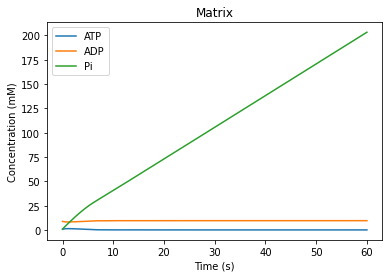

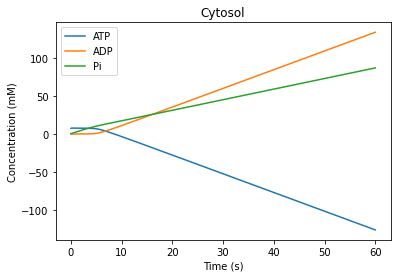

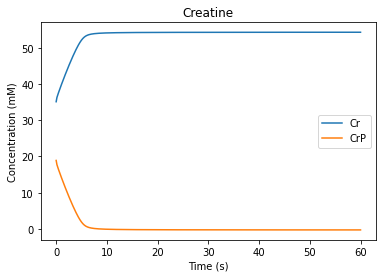

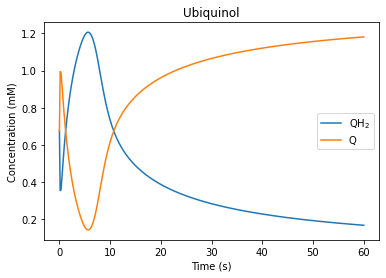

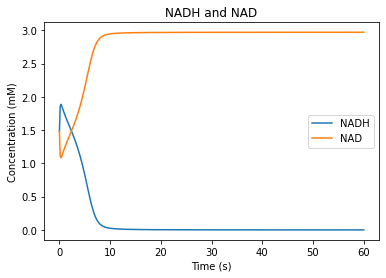

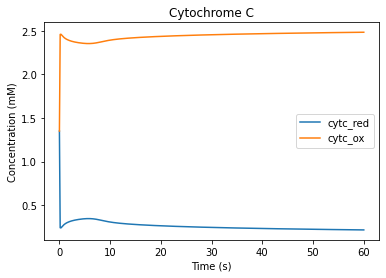

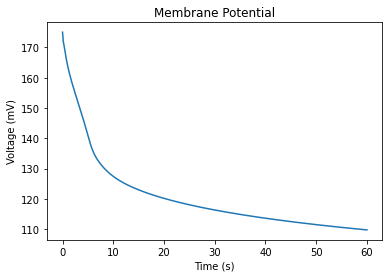

In [19]:
# Plotting Results 
plt.figure()
plt.title('Matrix')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mM)')
plt.plot(t_span, ATP_x*1000, label = 'ATP')
plt.plot(t_span, ADP_x*1000, label = 'ADP')
plt.plot(t_span, Pi_x*1000, label = 'Pi')
plt.legend()

plt.figure()
plt.title('Cytosol')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mM)')
plt.plot(t_span, ATP_e*1000, label = 'ATP')
plt.plot(t_span, ADP_e*1000, label = 'ADP')
plt.plot(t_span, Pi_e*1000, label = 'Pi')
plt.legend()


plt.figure()
plt.title('Creatine')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mM)')
plt.plot(t_span, Cr*1000, label = 'Cr')
plt.plot(t_span, (Crtot - Cr)*1000, label = 'CrP')
plt.legend()

plt.figure()
plt.title('Ubiquinol')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mM)')
plt.plot(t_span, QH2*1000, label = 'QH$_2$')
plt.plot(t_span, (Q_tot - QH2)*1000, label = 'Q')
plt.legend()

plt.figure()
plt.title('NADH and NAD')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mM)')
plt.plot(t_span, NADH_x*1000, label = 'NADH')
plt.plot(t_span, (NAD_tot -NADH_x)*1000, label = 'NAD')
plt.legend()

plt.figure()
plt.title('Cytochrome C')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mM)')
plt.plot(t_span, cytcred*1000, label = 'cytc_red')
plt.plot(t_span, (cytc_tot -cytcred)*1000, label = 'cytc_ox')
plt.legend()


plt.figure()
plt.title('Membrane Potential')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.plot(t_span, psi*1000)


In [20]:
psi

array([0.175     , 0.1718745 , 0.17058034, 0.16900234, 0.16746494,
       0.16605017, 0.16475895, 0.16357274, 0.16247159, 0.16143853,
       0.16046011, 0.15952575, 0.15862708, 0.15775726, 0.15691066,
       0.15608254, 0.15526876, 0.1544657 , 0.1536701 , 0.15287898,
       0.15208956, 0.1512992 , 0.15050547, 0.14970595, 0.14889837,
       0.14808062, 0.14725083, 0.14640739, 0.1455493 , 0.14467631,
       0.14378939, 0.14289111, 0.14198623, 0.14108209, 0.14018857,
       0.13931749, 0.13848113, 0.13769037, 0.13695284, 0.13627206,
       0.1356476 , 0.13507602, 0.13455202, 0.1340695 , 0.13362241,
       0.13320515, 0.13281288, 0.1324416 , 0.13208816, 0.13175017,
       0.13142585, 0.13111391, 0.13081335, 0.13052328, 0.13024325,
       0.12997253, 0.12971068, 0.12945727, 0.1292119 , 0.12897402,
       0.12874347, 0.12851982, 0.12830289, 0.12809222, 0.12788761,
       0.12768885, 0.12749563, 0.12730768, 0.1271248 , 0.12694675,
       0.12677327, 0.12660416, 0.12643926, 0.1262783 , 0.12612